In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.cuda.amp import GradScaler

# Import utils
from utils.Logger import Logger
from utils.Seed import set_seed
from utils.Splitter import stratified_split
from classes.FeatureDataset.CombinedFeatureDataset import CombinedFeatureDataset
from classes.FeatureDataset.WaveformFeatureDataset import WaveformFeatureDataset

# Import RawNet1 components
from classes.models.RawNets.RawNet1.model_RawNet1_preprocessed import RawNet
from classes.models.RawNets.RawNet1.trainer_RawNet1 import test_rawnet1, load_model_rawnet1

# Import RawNet2 components
from classes.models.RawNets.RawNet2.model_RawNet2_preprocessed import RawNet2
from classes.models.RawNets.RawNet2.trainer_RawNet2 import test_rawnet2, load_model_rawnet2

# Import RawNet3 components
from classes.models.RawNets.RawNet3.model_RawNet3_preprocessed import RawNet3
from classes.models.RawNets.RawNet3.trainer_RawNet3 import test_rawnet3, load_model_rawnet3

seed = 42
set_seed(42)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = ""

device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 32
learning_rate = 0.0001
epochs = 5

# Combined

In [2]:
# Load full dataset
print("==================== LOADING DATASET ====================\n")
full_dataset_combined = CombinedFeatureDataset("preprocessed_data/combined")
print("\n==================== DATASET LOADED ====================\n")

# Stratified dataset split
print("\n==================== SPLITTING DATASET ====================\n")
train_dataset_combined, val_dataset_combined, test_dataset_combined = stratified_split(full_dataset_combined, splits=(0.7, 0.15, 0.15), seed=seed)

train_loader_combined = DataLoader(train_dataset_combined, batch_size=batch_size, shuffle=True)
val_loader_combined = DataLoader(val_dataset_combined, batch_size=batch_size, shuffle=False)
test_loader_combined = DataLoader(test_dataset_combined, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Total samples: {len(full_dataset_combined)}")
print(f"Train samples: {len(train_dataset_combined)}")
print(f"Validation samples: {len(val_dataset_combined)}")
print(f"Test samples: {len(test_dataset_combined)}")

==================== LOADING DATASET ====================

Skipped 0 files due to NaNs/Infs.

==================== DATASET LOADED ====================


==================== SPLITTING DATASET ====================

Total samples: 71118
Train samples: 49782
Validation samples: 10667
Test samples: 10669


In [4]:
# List all data used for test set
print("\nTest set data items:")
for idx in range(len(test_dataset_combined)):
    data_item = test_dataset_combined[idx]
    # If your dataset returns (features, label, path), adjust accordingly
    if isinstance(data_item, tuple) and len(data_item) > 2:
        for data in data_item:
            if isinstance(data, str):
                print(f"Index {idx}: {data}")
    else:
        print(f"Index {idx}: {data_item}")


Test set data items:
Index 0: (tensor([0.0000, 0.0000, 0.0000,  ..., 0.0875, 0.0538, 0.7546]), 1)
Index 1: (tensor([-2.6550e-03, -6.7139e-04,  1.3123e-03,  ...,  1.2667e-01,
        -3.8833e-03,  8.3828e-01]), 1)
Index 2: (tensor([-6.4087e-04, -9.4604e-04, -1.1292e-03,  ...,  6.1159e-02,
         3.0339e-02,  8.3731e-01]), 1)
Index 3: (tensor([0.0000, 0.0000, 0.0000,  ..., 0.1188, 0.0605, 0.6790]), 1)
Index 4: (tensor([0.0244, 0.0281, 0.0326,  ..., 0.1188, 0.0895, 0.6131]), 1)
Index 5: (tensor([1.2207e-04, 2.7466e-04, 1.5259e-04,  ..., 5.5054e-02, 1.2817e-02,
        8.6713e-01]), 1)
Index 6: (tensor([0.0295, 0.0342, 0.0381,  ..., 0.0851, 0.0252, 0.8100]), 1)
Index 7: (tensor([6.1035e-05, 9.1553e-05, 1.5259e-04,  ..., 1.0416e-01, 2.7516e-02,
        7.7210e-01]), 1)
Index 8: (tensor([0.0000, 0.0000, 0.0000,  ..., 0.0794, 0.0312, 0.7905]), 1)
Index 9: (tensor([-0.0074, -0.0107, -0.0017,  ...,  0.0511,  0.0211,  0.8443]), 1)
Index 10: (tensor([0.0000, 0.0000, 0.0000,  ..., 0.0770, 0.041

In [4]:
# Show class frequency for each dataset (label mapping: Bonafide=1, Spoof=0)
from collections import Counter

label_map = {1: "Bonafide", 0: "Spoof"}

def get_class_counts(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))]
    return Counter(labels)

print("\nClass frequencies:")
for name, ds in zip(['Train', 'Validation', 'Test'], [train_dataset_combined, val_dataset_combined, test_dataset_combined]):
    counts = get_class_counts(ds)
    # Map numeric labels to class names for display
    named_counts = {label_map.get(k, k): v for k, v in counts.items()}
    print(f"{name} set class counts: {named_counts}")


Class frequencies:
Train set class counts: {'Bonafide': 12978, 'Spoof': 36804}
Validation set class counts: {'Bonafide': 2781, 'Spoof': 7886}
Test set class counts: {'Bonafide': 2781, 'Spoof': 7888}


## RawNet1

Loaded model from pretrained_weights\combined\RawNet1\rawnet1_combined-ep_100-bs_32-lr_0.0001.pth (epoch 99)
              --> Val Acc: 99.99%
              --> Balanced Acc: 0.9999 | Precision: 0.9996
              --> Recall: 1.0000 | F1: 0.9998 | F2: 0.9999
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0001
              --> CLLR: 0.0004


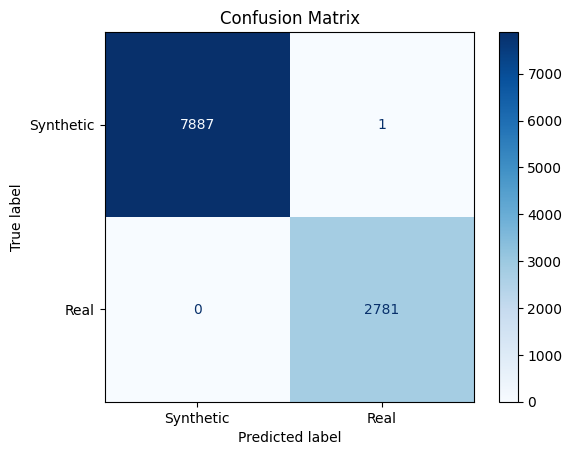

In [4]:
combined_model_config = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2,
    'input_length': 16000 * 4 + 24
}

# --- Set up model, optimizer, and scaler ---
model = RawNet(combined_model_config, device).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet1(
    model, optimizer, scaler,
    path=r"pretrained_weights\combined\RawNet1\rawnet1_combined-ep_100-bs_32-lr_0.0001.pth"
)

predictions, targets, metrics = test_rawnet1(model, test_loader_combined, device=device)

## RawNet2

Loaded model from pretrained_weights\combined\RawNet2\rawnet2_combined-ep_100-bs_32-lr_0.0001.pth (epoch 99)
              --> Val Acc: 99.97%
              --> Balanced Acc: 0.9996 | Precision: 0.9996
              --> Recall: 0.9993 | F1: 0.9995 | F2: 0.9994
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0004
              --> CLLR: 0.0041


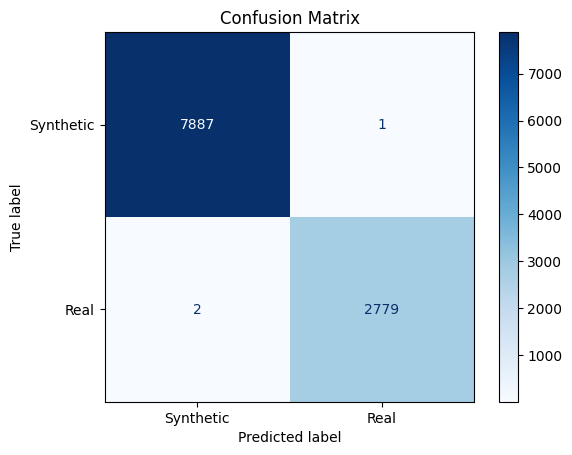

In [5]:
combined_model_config2 = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2,
    'nb_samp': 16000 * 4 + 24
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Set up model, optimizer, and scaler ---
model = RawNet2(combined_model_config2).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet2(
    model, optimizer, scaler,
    path=r"pretrained_weights\combined\RawNet2\rawnet2_combined-ep_100-bs_32-lr_0.0001.pth"
)

predictions, targets, metrics = test_rawnet2(model, test_loader_combined, device=device)

## RawNet3

Loaded model from pretrained_weights\combined\RawNet3\rawnet3_combined-ep_23-bs_32-lr_0.0001.pth (epoch 22)
              --> Val Acc: 99.98%
              --> Balanced Acc: 0.9998 | Precision: 0.9996
              --> Recall: 0.9996 | F1: 0.9996 | F2: 0.9996
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0001
              --> CLLR: 0.0017


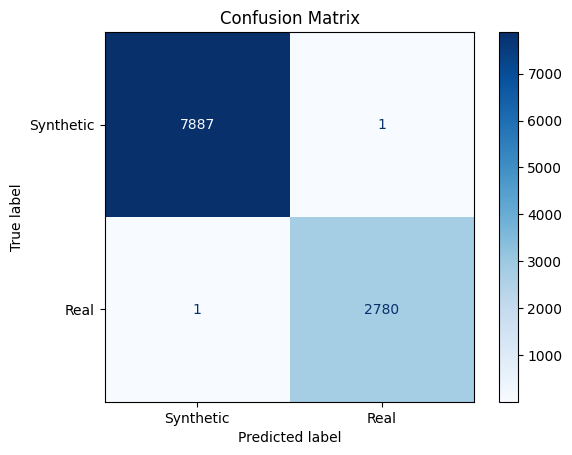

In [3]:
combined_model_config3 = {
    "nOut": 2,
    "sinc_stride": 10,
    "encoder_type": "ECA",
    "log_sinc": True,
    "norm_sinc": "mean_std",
    "out_bn": True
}

# --- Set up model, optimizer, and scaler ---
model = RawNet3(**combined_model_config3).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet3(
    model, optimizer, scaler,
    path=r"pretrained_weights\combined\RawNet3\rawnet3_combined-ep_23-bs_32-lr_0.0001.pth"
)

predictions, targets, metrics = test_rawnet3(model, test_loader_combined, device=device)

# Combined (ver 2)

Loaded model from pretrained_weights\RawNet1\rawnet1_diff_pipeline-ep_100-bs_32-lr_0.0001.pth (epoch 99)
              --> Val Acc: 100.00%
              --> Balanced Acc: 1.0000 | Precision: 1.0000
              --> Recall: 1.0000 | F1: 1.0000 | F2: 1.0000
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0000
              --> CLLR: 0.0000


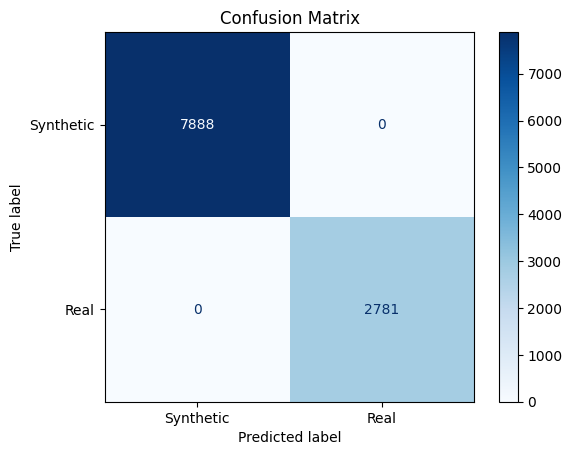

In [6]:
# Import RawNet1 components
from classes.models.RawNets.RawNet1.model_RawNet1_preprocessed_diff_pipeline import RawNet as RawNetv2

combined_model_config = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2,
    'input_length': 16000 * 4 + 24
}

# --- Set up model, optimizer, and scaler ---
model = RawNetv2(combined_model_config, device).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet1(
    model, optimizer, scaler,
    path=r"pretrained_weights\RawNet1\rawnet1_diff_pipeline-ep_100-bs_32-lr_0.0001.pth"
)

predictions, targets, metrics = test_rawnet1(model, test_loader_combined, device=device)

Loaded model from pretrained_weights\RawNet2\rawnet2_diff_pipeline-ep_100-bs_32-lr_0.0001.pth (epoch 99)
              --> Val Acc: 99.99%
              --> Balanced Acc: 0.9999 | Precision: 0.9996
              --> Recall: 1.0000 | F1: 0.9998 | F2: 0.9999
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0001
              --> CLLR: 0.0009


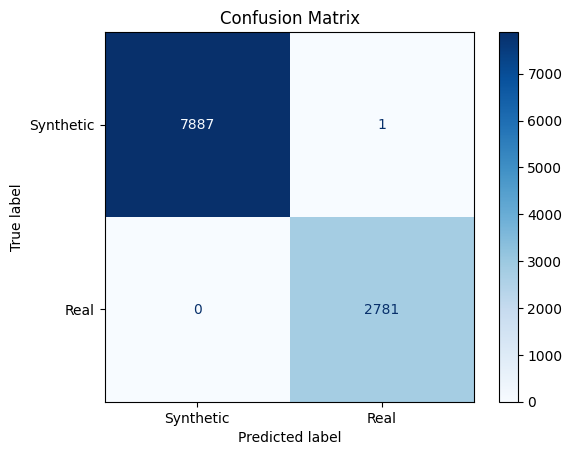

In [10]:
# Import RawNet2 components
from classes.models.RawNets.RawNet2.model_RawNet2_preprocessed_diff_pipeline import RawNet2 as RawNet2v2

combined_model_config2 = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2,
    'nb_samp': 16000 * 4
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Set up model, optimizer, and scaler ---
model = RawNet2v2(combined_model_config2).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet2(
    model, optimizer, scaler,
    path=r"pretrained_weights\RawNet2\rawnet2_diff_pipeline-ep_100-bs_32-lr_0.0001.pth"
)

predictions, targets, metrics = test_rawnet2(model, test_loader_combined, device=device)

# Waveform

In [11]:
# Load full dataset
print("==================== LOADING DATASET ====================\n")
full_dataset_waveform = WaveformFeatureDataset("preprocessed_data/waveform")
print("\n==================== DATASET LOADED ====================\n")

# Stratified dataset split
print("\n==================== SPLITTING DATASET ====================\n")
train_dataset_waveform, val_dataset_waveform, test_dataset_waveform = stratified_split(full_dataset_waveform, splits=(0.7, 0.15, 0.15), seed=seed)

train_loader_waveform = DataLoader(train_dataset_waveform, batch_size=batch_size, shuffle=True)
val_loader_waveform = DataLoader(val_dataset_waveform, batch_size=batch_size, shuffle=False)
test_loader_waveform = DataLoader(test_dataset_waveform, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Total samples: {len(full_dataset_waveform)}")
print(f"Train samples: {len(train_dataset_waveform)}")
print(f"Validation samples: {len(val_dataset_waveform)}")
print(f"Test samples: {len(test_dataset_waveform)}")

==================== LOADING DATASET ====================

Skipped 0 files due to NaNs/Infs.

==================== DATASET LOADED ====================


==================== SPLITTING DATASET ====================

Total samples: 71118
Train samples: 49782
Validation samples: 10667
Test samples: 10669


In [3]:
# Show class frequency for each dataset (label mapping: Bonafide=1, Spoof=0)
from collections import Counter

label_map = {1: "Bonafide", 0: "Spoof"}

def get_class_counts(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))]
    return Counter(labels)

print("\nClass frequencies:")
for name, ds in zip(['Train', 'Validation', 'Test'], [train_dataset_waveform, val_dataset_waveform, test_dataset_waveform]):
    counts = get_class_counts(ds)
    # Map numeric labels to class names for display
    named_counts = {label_map.get(k, k): v for k, v in counts.items()}
    print(f"{name} set class counts: {named_counts}")


Class frequencies:
Train set class counts: {'Bonafide': 12978, 'Spoof': 36804}
Validation set class counts: {'Bonafide': 2781, 'Spoof': 7886}
Test set class counts: {'Bonafide': 2781, 'Spoof': 7888}


## RawNet1

Loaded model from pretrained_weights\waveform\RawNet1\rawnet1_waveform-ep_100-bs_32-lr_0.0001.pth (epoch 99)
              --> Val Acc: 100.00%
              --> Balanced Acc: 1.0000 | Precision: 1.0000
              --> Recall: 1.0000 | F1: 1.0000 | F2: 1.0000
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0000
              --> CLLR: 0.0000


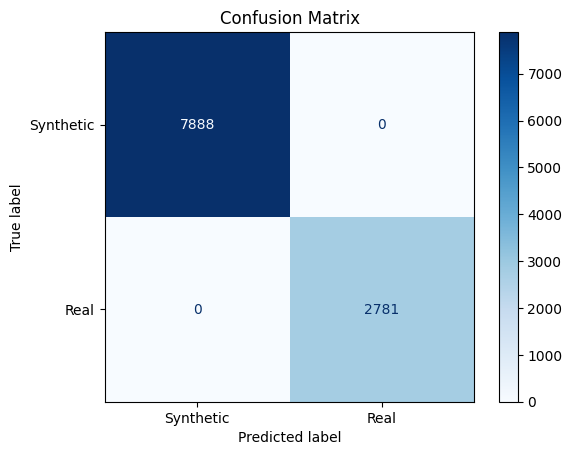

In [4]:
waveform_model_config = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2,
    'input_length': 16000 * 4
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Set up model, optimizer, and scaler ---
model = RawNet(waveform_model_config, device).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet1(
    model, optimizer, scaler,
    path=r"pretrained_weights\waveform\RawNet1\rawnet1_waveform-ep_100-bs_32-lr_0.0001.pth"
)

predictions, targets, metrics = test_rawnet1(model, test_loader_waveform, device=device)

## RawNet2

Loaded model from pretrained_weights\waveform\RawNet2\rawnet2_waveform-ep_100-bs_32-lr_0.0001.pth (epoch 99)
              --> Val Acc: 99.93%
              --> Balanced Acc: 0.9987 | Precision: 0.9996
              --> Recall: 0.9975 | F1: 0.9986 | F2: 0.9979
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0012
              --> CLLR: 0.0172


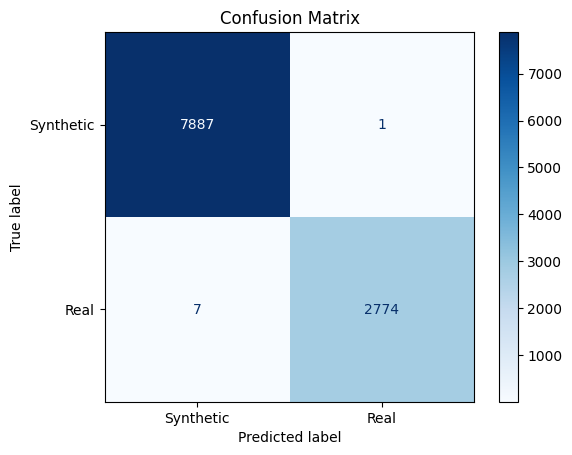

In [ ]:
waveform_model_config2 = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2,
    'nb_samp': 16000 * 4
}

# --- Set up model, optimizer, and scaler ---
model = RawNet2(waveform_model_config2).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet2(
    model, optimizer, scaler,
    path=r"pretrained_weights\waveform\RawNet2\rawnet2_waveform-ep_100-bs_32-lr_0.0001.pth"
)

predictions, targets, metrics = test_rawnet2(model, test_loader_waveform, device=device)

## RawNet3

Loaded model from pretrained_weights\waveform\RawNet3\rawnet3_waveform-ep_23-bs_32-lr_0.0001.pth (epoch 22)
              --> Val Acc: 100.00%
              --> Balanced Acc: 1.0000 | Precision: 1.0000
              --> Recall: 1.0000 | F1: 1.0000 | F2: 1.0000
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0000
              --> CLLR: 0.0013


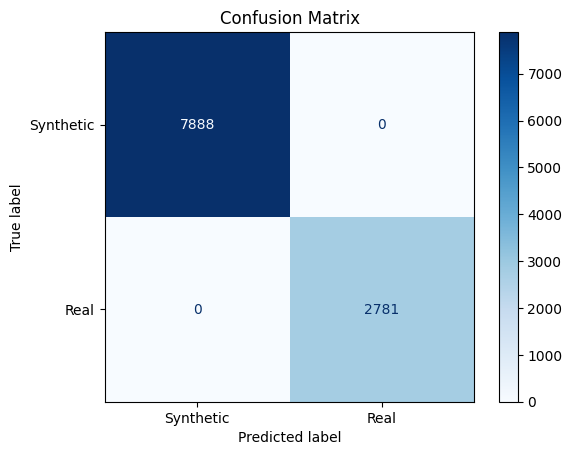

In [12]:
waveform_model_config3 = {
    "nOut": 2,
    "sinc_stride": 10,
    "encoder_type": "ECA",
    "log_sinc": True,
    "norm_sinc": "mean_std",
    "out_bn": True
}

# --- Set up model, optimizer, and scaler ---
model = RawNet3(**waveform_model_config3).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet3(
    model, optimizer, scaler,
    path=r"pretrained_weights\waveform\RawNet3\rawnet3_waveform-ep_23-bs_32-lr_0.0001.pth"
)

predictions, targets, metrics = test_rawnet3(model, test_loader_waveform, device=device)